In [1]:
import os, sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=3

import numpy as np
import torch

env: CUDA_VISIBLE_DEVICES=3


In [23]:
from lib.agent import SimpleAgent
from lib.algorithm import QLearningTrainer

agent = SimpleAgent(hid_size=256, lstm_size=128, gcn_size=256, vertex_emb_size=64, walk_emb_size=64).cuda()
trainer = QLearningTrainer(agent)

### Problem generator

In [7]:
from lib.problem import generate_erdos_renyi_problems, solve_heapsearch
problem_maker = generate_erdos_renyi_problems(num_vertices=50, edge_prob=0.25, 
                                              walk_length_range=[40, 60])

59 59


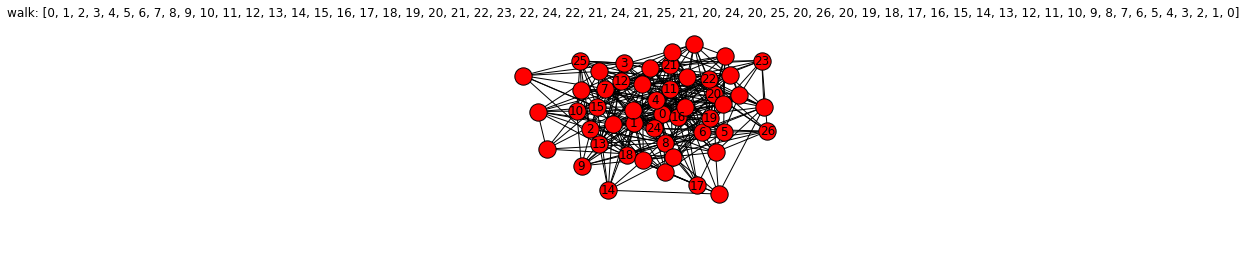

In [21]:
# each problem contains (1) graph, (2) anonymous walk and (3) initial vertex id
problem = next(problem_maker)

with torch.no_grad():
    solution, transitions = solve_heapsearch(problem, max_steps=1000)
    
problem.path = solution
print(len(solution), len(problem.walk))
problem.render()

### Training

In [19]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm, trange
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

td_error_history, reward_history = [], []

In [20]:
problems = [
    next(problem_maker) for i in trange(10)
]


100%|██████████| 10/10 [00:00<00:00, 305.24it/s]

In [29]:
emb = agent.embed_walk([0, 1, 2, 3, 4, 5, 4, 3, 2, 1, 0], device='cuda')

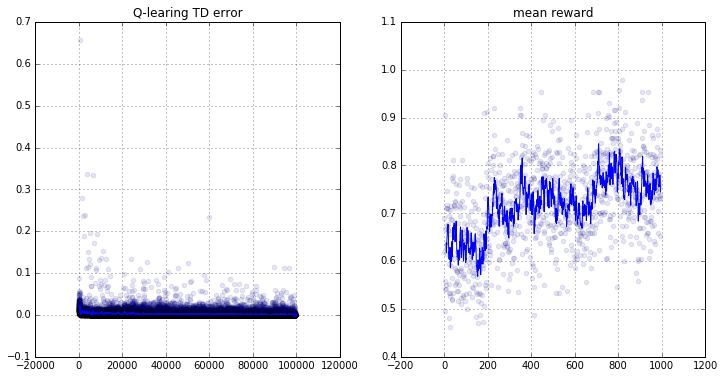

100%|██████████| 100000/100000 [39:59<00:00, 41.68it/s]


In [21]:
import random 

for t in trange(100000):
#     problem = next(problem_maker)
    problem = random.choice(problems)
    
    with torch.no_grad():
        solution, transitions = agent.solve(problem, epsilon=0.1, device='cuda')

    td_error = trainer.train_on_batch(problem, transitions, step=True, device='cuda')
    td_error_history.append(td_error)

    if t % 100 == 0:
        trainer.update_target_network()

    if t % 100 == 0:
        rewards = []
        for i in range(10):
            problem = random.choice(problems)
            with torch.no_grad():
                solution, _ = agent.solve(problem, epsilon=0.0, device='cuda')
            rewards.append(len(solution) / len(problem.walk))
            
        reward_history.append(np.mean(rewards))
        
    if t % 500 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1,2,1)
        plt.title('Q-learing TD error'); plt.grid()
        plt.scatter(np.arange(len(td_error_history)), td_error_history, alpha=0.1)
        plt.plot(moving_average(td_error_history, span=100, min_periods=100))
        
        plt.subplot(1,2,2)
        plt.title('mean reward'); plt.grid()
        plt.scatter(np.arange(len(reward_history)), reward_history, alpha=0.1)
        plt.plot(moving_average(reward_history, span=10, min_periods=10))
        plt.show()
    
    